In [1]:
import cvxopt
import pickle as pkl
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from utils import (
    get_all_atom_types,
    clean_dataset,
    WLK_linear,
    WLK_gaussian,
    WL,
    nth_order_walk,
    weisfeiler_lehman,
    KernelSVC,
    cross_val
)

In [2]:
cvxopt.solvers.options['show_progress'] = False

Reading the data:

In [3]:
with open('data/training_data.pkl', 'rb') as file:
    train_graphs = pkl.load(file)

with open('data/test_data.pkl', 'rb') as file:
    test_graphs = pkl.load(file)

with open('data/training_labels.pkl', 'rb') as file:
    train_labels = pkl.load(file)

Cleaning the data:

In [4]:
train_graphs = clean_dataset(train_graphs)

Plotting the data:

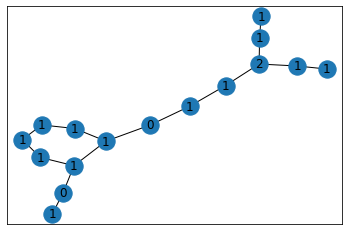

In [5]:
idx=0
nx.draw_networkx(train_graphs[idx], labels=get_all_atom_types(train_graphs[idx]))

## Building the Gram Matrix

### Walk kernel Gram Matrix:

In [13]:
import numpy as np
from scipy.sparse import lil_matrix, kron,identity
from scipy.sparse.linalg import lsqr
import networkx as nx
import time 


lmb=0.5
tolerance=1e-8
maxiter=20


def norm(adj_mat):
    """Normalize adjacency matrix"""
    norm = adj_mat.sum(axis=0)
    norm[norm == 0] = 1
    return adj_mat / norm

def random_walk_kernel(g1, g2):
    """Compute random walk kernel for networkx graphs g1 and g2 according to formula (16) of Graph Kernels"""
    g1=nx.adj_matrix(g1)
    g2=nx.adj_matrix(g2)
    # norm1, norm2 - normalized adjacency matrixes
    norm1 = norm(g1)
    norm2 = norm(g2)
    # if graph is unweighted, W_prod = kron(a_norm(g1)*a_norm(g2))
    #w_prod représente W_x
    w_prod = kron(lil_matrix(norm1), lil_matrix(norm2))
    #starting_prob=stop_prob=q_x=p_x
    starting_prob = np.ones(w_prod.shape[0]) / (w_prod.shape[0])
    stop_prob = starting_prob
    # first solve (I - lambda * W_prod) * x = p_x => x=(I - lambda * W_prod)^(-1)*p_x
    A = identity(w_prod.shape[0]) - (w_prod * lmb)
    x = lsqr(A, starting_prob)
    #then multiply by transpose(q_x) to obtain kernel value
    res = stop_prob.T.dot(x[0])
    return res

In [15]:
n = 3

N_train = len(train_graphs)
indexes_train = np.arange(N_train)

N_test = len(test_graphs)
indexes_test = np.arange(N_test)

G_train = np.zeros((N_train, N_train))
for i in tqdm(range(N_train)):
    for j in range(i, N_train):
        g = random_walk_kernel(train_graphs[i], train_graphs[j])
        G_train[i,j] = g
        G_train[j,i] = g

  0%|          | 8/6000 [03:16<40:54:34, 24.58s/it]


KeyboardInterrupt: 

### Weisfeiler Lehman (WL) Gram Matrix:

In [6]:
max_iter = 2
h = 4
normalize = False

N_train = len(train_graphs)
indexes_train = np.arange(N_train)

N_test = len(test_graphs)
indexes_test = np.arange(N_test)

X_train = []
for i in indexes_train:
    #X_train.append(weisfeiler_lehman(train_graphs[i], h=h, normalize=normalize))
    X_train.append(WL(train_graphs[i], max_iter=max_iter))

X_test = []
for i in indexes_test:
    #X_test.append(weisfeiler_lehman(test_graphs[i], h=h, normalize=normalize))
    X_test.append(WL(test_graphs[i], max_iter=max_iter))

In [8]:
G_train = np.zeros((N_train, N_train))
for i in tqdm(range(N_train)):
    for j in range(i, N_train):
        g = WLK_gaussian(X_train[i], X_train[j])
        G_train[i,j] = g
        G_train[j,i] = g

100%|██████████| 5774/5774 [06:35<00:00, 14.60it/s] 


In [9]:
G_test = np.zeros((N_test, N_train))
for i in tqdm(range(N_test)):
    for j in range(N_train):
        G_test[i,j] = WLK_gaussian(X_test[i], X_train[j])

100%|██████████| 2000/2000 [05:49<00:00,  5.73it/s]


In [10]:
sigma = 4.
G_train_exp = np.exp(-0.5*G_train/(sigma**2))
G_test_exp = np.exp(-0.5*G_test/(sigma**2))

## SVM with Cross Validation:

Cross validation:

In [11]:
from utils import cross_val

In [11]:
C = 1.
class_weights=False

models, scores, test_preds = cross_val(
    G_train=G_train_exp,
    train_labels=train_labels,
    G_test=G_test_exp,
    C=C,
    class_weights=class_weights
)

##### 5-FOLD CROSS VAL: starting fold 1 #####
Val score: 0.8165029036963641


##### 5-FOLD CROSS VAL: starting fold 2 #####
Val score: 0.8248081841432225


##### 5-FOLD CROSS VAL: starting fold 3 #####
Val score: 0.8437541839603695


##### 5-FOLD CROSS VAL: starting fold 4 #####
Val score: 0.8113910954160289


##### 5-FOLD CROSS VAL: starting fold 5 #####
Val score: 0.8210877550448168




In [12]:
np.mean(scores)

0.8235088244521604

In [13]:
y_test_pred = np.mean(test_preds, axis=0)

## Grid search:

In [11]:
sigmas = [2., 4., 8.]
Cs = [1., 10., 100., 1000.]
weights = [True, False]

results = []

best_score = 0
y_test_pred = np.zeros(2000)

for sigma in sigmas:
    G_train_exp = np.exp(-0.5*G_train/(sigma**2))
    G_test_exp = np.exp(-0.5*G_test/(sigma**2))

    for C in Cs:
        for weight in weights:

            models, scores, test_preds = cross_val(
                G_train=G_train_exp,
                train_labels=train_labels,
                G_test=G_test_exp,
                C=C,
                class_weights=weight,
                seed=42,
                verbose=False
            )

            mean_score = np.mean(scores)

            parameters = {
                'max_iter':2,
                'sigma':sigma,
                'C':C,
                'class_weights':weight,
                'mean_score':mean_score
            }

            results.append(parameters)

            if mean_score > best_score:
                best_score = mean_score
                y_test_pred = np.mean(test_preds, axis=0)

                print(f'New best model \n   sigma = {sigma}, C = {C}, class weights = {weight} \n   score = {mean_score}')

New best model 
   sigma = 2.0, C = 1.0, class weights = True 
   score = 0.8273615033166944
New best model 
   sigma = 2.0, C = 1.0, class weights = False 
   score = 0.8312764810927165
New best model 
   sigma = 2.0, C = 10.0, class weights = False 
   score = 0.8314625747725465
New best model 
   sigma = 4.0, C = 1.0, class weights = True 
   score = 0.8449480092378092
New best model 
   sigma = 4.0, C = 1.0, class weights = False 
   score = 0.8489414723622882


### Old implementation

In [6]:
#from sklearn.model_selection import train_test_split

In [7]:
#train_idx, val_idx = train_test_split(range(len(train_graphs)), test_size=0.2, random_state=42)
train_idx = range(6000)
N_train = len(train_idx)
# N_val = len(val_idx)
N_test = len(test_graphs)

In [9]:
max_iter = 2

X_train = []
for i in train_idx:
    X_train.append(WL(train_graphs[i], max_iter=max_iter))
    #X_train.append(weisfeiler_lehman(train_graphs[i], h=3))

# X_val = []
# for i in val_idx:
#     X_val.append(WL(train_graphs[i], max_iter=max_iter))
#     #X_val.append(weisfeiler_lehman(train_graphs[i], h=3))

X_test = []
for i in range(N_test):
    X_test.append(WL(test_graphs[i], max_iter=max_iter))
    #X_val.append(weisfeiler_lehman(train_graphs[i], h=3))

y_train = train_labels[train_idx]
# y_val = train_labels[val_idx]

Computing the Gram matrices:

In [10]:
G_train = np.zeros((N_train, N_train))
for i in tqdm(range(N_train)):
    for j in range(i, N_train):
        g = WLK_gaussian(X_train[i], X_train[j])
        G_train[i,j] = g
        G_train[j,i] = g

100%|██████████| 6000/6000 [03:27<00:00, 28.96it/s] 


In [10]:
# G_val = np.zeros((N_val, N_train))
# for i in tqdm(range(N_val)):
#     for j in range(N_train):
#         G_val[i,j] = WLK_gaussian(X_val[i], X_train[j])

100%|██████████| 1200/1200 [01:52<00:00, 10.63it/s]


In [11]:
G_test = np.zeros((N_test, N_train))
for i in tqdm(range(N_test)):
    for j in range(N_train):
        G_test[i,j] = WLK_gaussian(X_test[i], X_train[j])

100%|██████████| 2000/2000 [02:41<00:00, 12.37it/s]


#### Fitting SVC:

In [12]:
# RBF Kernel:
sigma = 2.
G_train_exp = np.exp(-0.5*G_train/(sigma**2))
#G_val_exp = np.exp(-0.5*G_val/(sigma**2))
G_test_exp = np.exp(-0.5*G_test/(sigma**2))

In [13]:
C=10.
model = KernelSVC(C=C)
model.fit(G_train_exp, y_train, method='cvxopt', class_weights={-1:1, 1:3})

     pcost       dcost       gap    pres   dres
 0:  3.5217e+04 -1.0811e+06  2e+06  3e-01  2e-14
 1:  2.9989e+04 -1.7792e+05  2e+05  2e-02  1e-14
 2:  8.8048e+03 -5.0577e+04  6e+04  5e-03  1e-14
 3:  3.1205e+03 -2.7378e+04  3e+04  2e-03  7e-15
 4: -7.3351e+02 -6.9843e+03  6e+03  2e-04  7e-15
 5: -1.3262e+03 -4.2104e+03  3e+03  5e-05  4e-15
 6: -1.5737e+03 -2.3794e+03  8e+02  1e-05  4e-15
 7: -1.6219e+03 -1.9077e+03  3e+02  4e-06  3e-15
 8: -1.6362e+03 -1.7464e+03  1e+02  7e-14  4e-15
 9: -1.6419e+03 -1.6642e+03  2e+01  2e-13  3e-15
10: -1.6433e+03 -1.6480e+03  5e+00  1e-13  3e-15
11: -1.6437e+03 -1.6443e+03  6e-01  9e-14  3e-15
12: -1.6438e+03 -1.6439e+03  1e-01  7e-14  3e-15
13: -1.6438e+03 -1.6438e+03  1e-02  5e-14  3e-15
14: -1.6438e+03 -1.6438e+03  3e-04  3e-14  3e-15
Optimal solution found.


In [14]:
y_train_pred = model.predict(G_train_exp)
# y_val_pred = model.predict(G_val_exp)
y_test_pred = model.predict(G_test_exp)

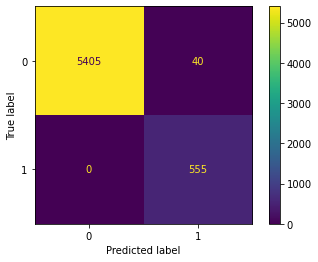

In [15]:
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()
plt.show()

In [16]:
roc_auc_score(y_train, y_train_pred)

0.9963269054178144

#### Fitting kNN:

In [10]:
def kNN(G_val, y_train, k=3):
    """
    Given a feature dictionnary whose label is to be predicted, the WL feature vector of the graphs in the training set 
    and the number of nearest neighbors k, returns the predicted label of G.
    """
    neighbours = np.argpartition(G_val, k, axis=1)[:,:k]

    y_pred = []
    for i in range(len(neighbours)):
        is_positive = sum([y_train[i] for i in neighbours[i]])
        if is_positive > k/2 :
            y_pred.append(1)
        else:
            y_pred.append(0)
    return np.array(y_pred)

In [23]:
y_pred = kNN(G_val, y_train, k=1)

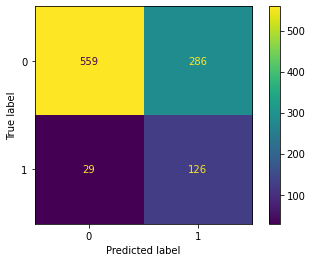

In [27]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()
plt.show()

In [70]:
y_pred.sum()/len(y_pred)

0.298

## Submission:

In [ ]:
Yte = {'Predicted' : np.array(y_test_pred, dtype=np.float32)}
dataframe = pd.DataFrame(Yte)
dataframe.index += 1
dataframe.to_csv('test_pred.csv', index_label='Id')

In [ ]:
dataframe = pd.DataFrame(results)
dataframe.to_csv('grid_search_results.csv')